# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Reading and Understading our Data

In [2]:
df = pd.read_csv(".//creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Exploratory Data Analysis

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

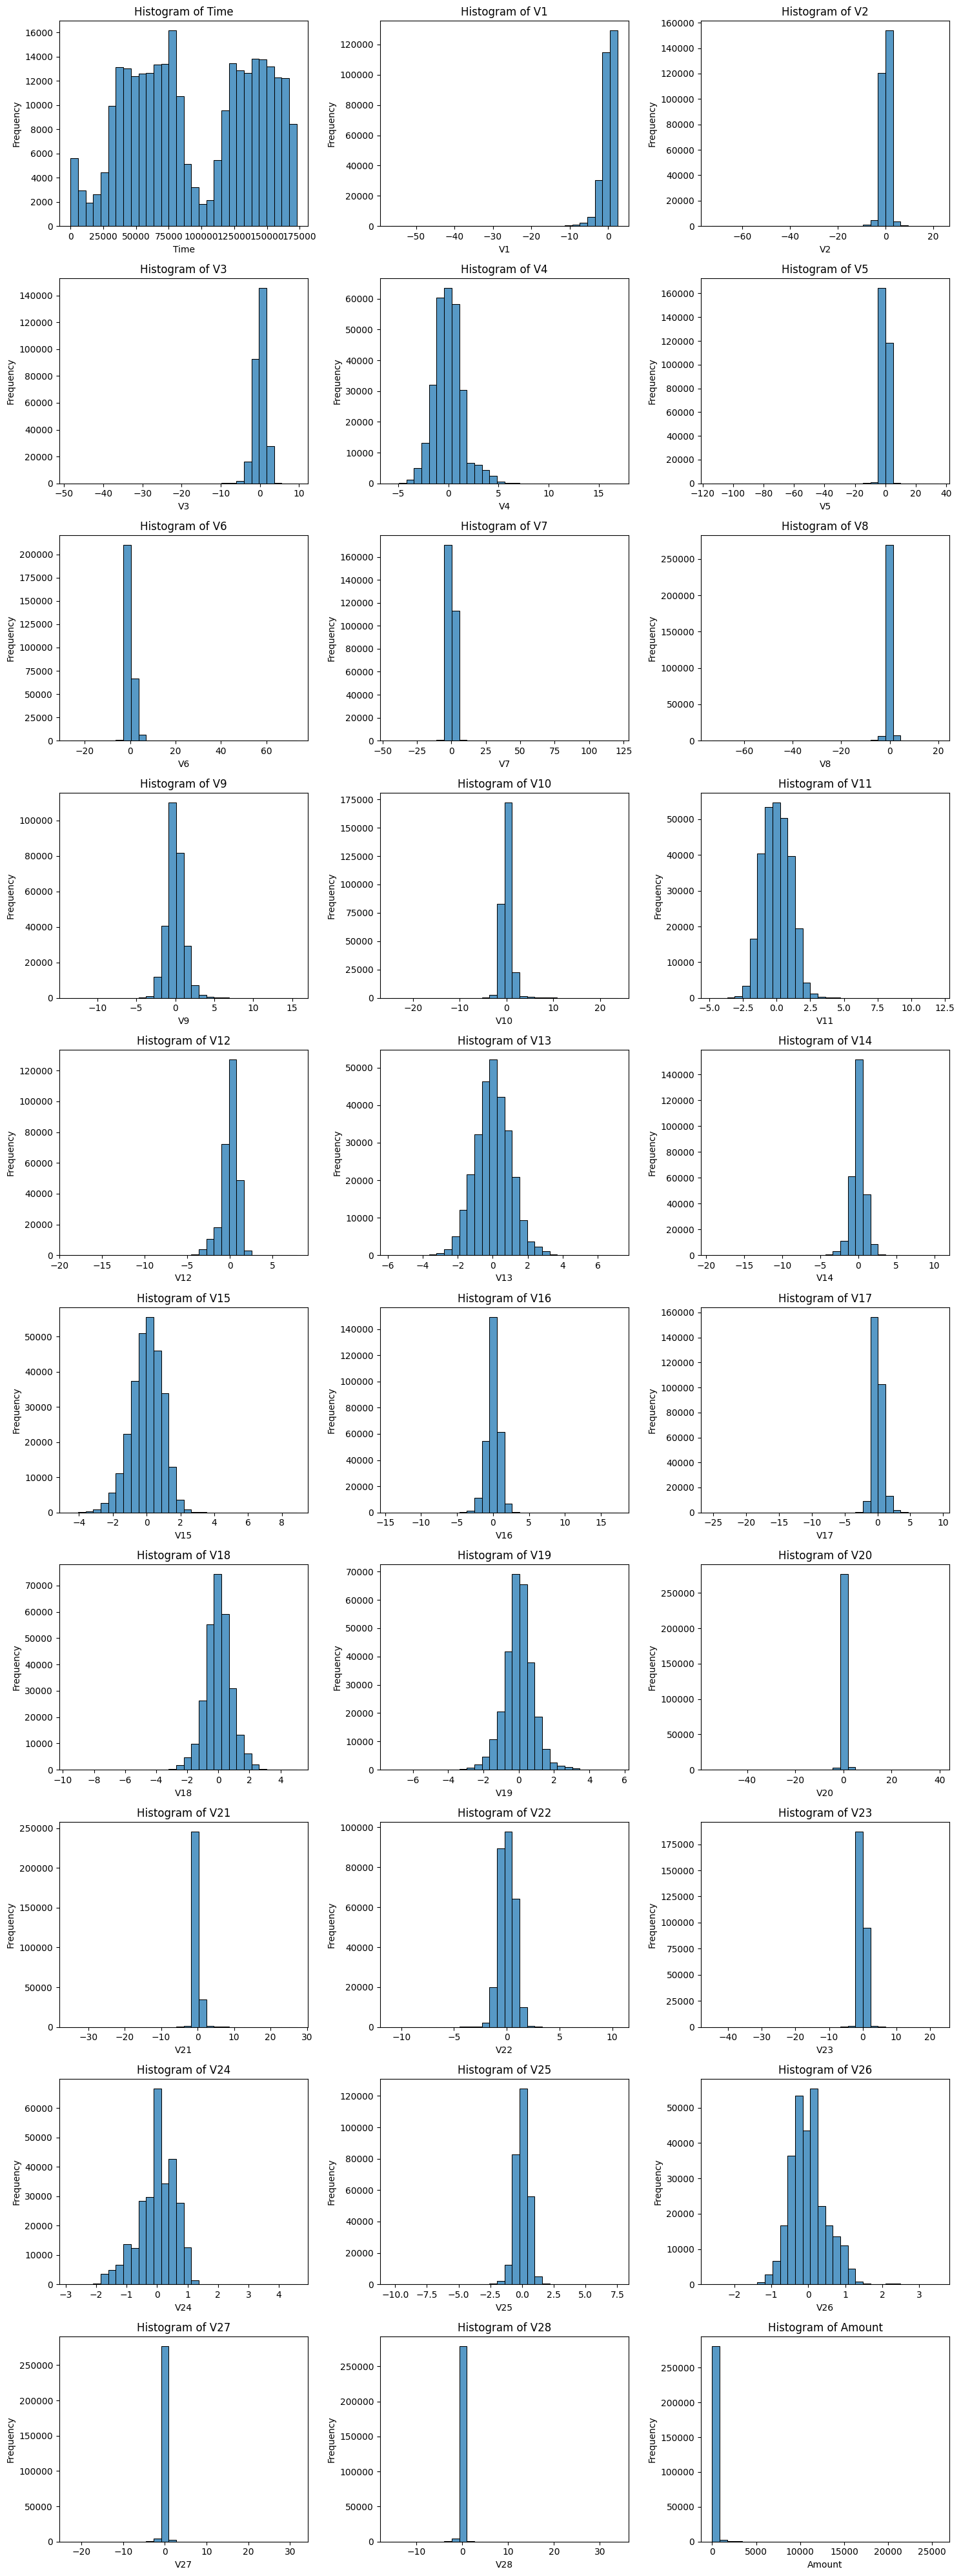

In [7]:
features = df.columns[:-1]

fig, axes = plt.subplots(10, 3, figsize=(15, 40))  

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time', 'Amount'], axis=1, inplace=True)

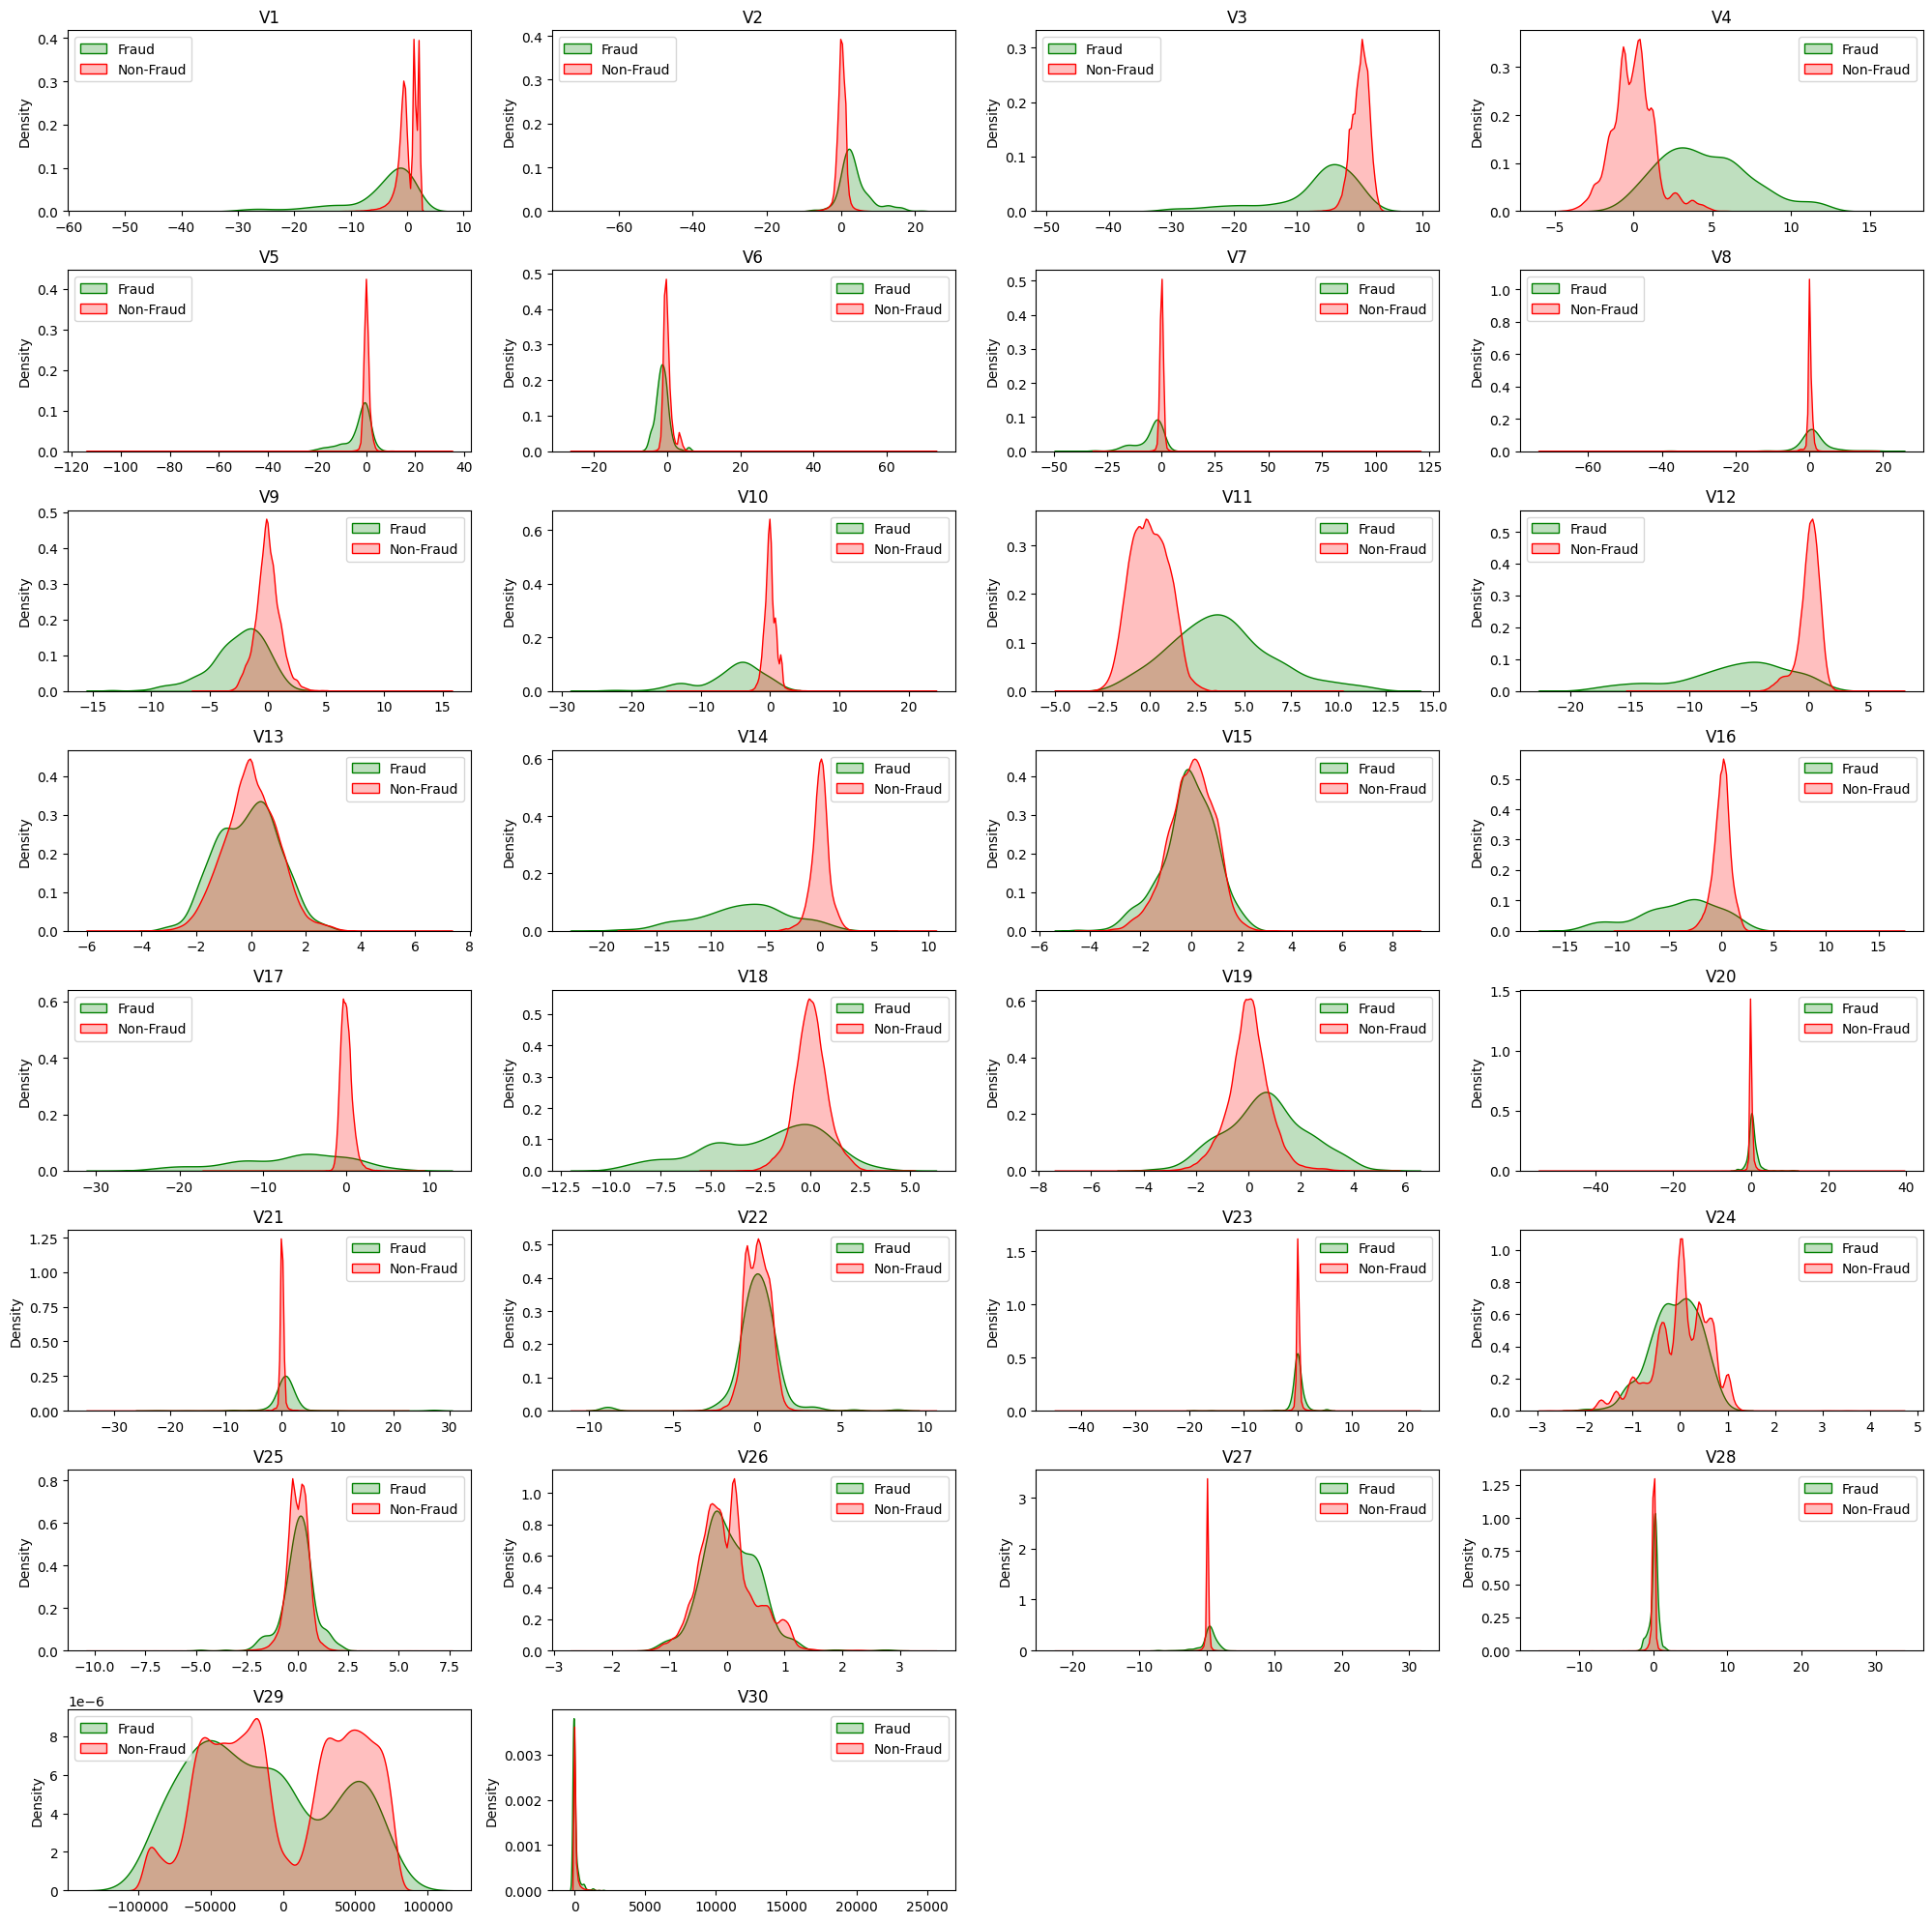

In [9]:
sample_columns = df.drop('Class', axis=1).columns

n_cols = 4  
n_rows = (len(sample_columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(20,10*2))  

for n, col in enumerate(sample_columns, 1):
    plt.subplot(n_rows, n_cols, n)  
    sns.kdeplot(df[df['Class'] == 1][col], color='g', label='Fraud', fill=True)
    sns.kdeplot(df[df['Class'] == 0][col], color='r', label='Non-Fraud', fill=True)
    plt.ylabel('Density')
    plt.title(col)
    plt.xlabel('')
    plt.legend()

plt.tight_layout()
plt.show()

In [10]:
features = df.columns[:-1]
df_transformed = df.copy()

def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

skewness_before = df.skew()

for col in features:
    if abs(df[col].skew()) > 0.75:  
        df_transformed[col] = log_transform_skewed(df[col])

skewness_after = df_transformed.skew()

skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

skewness_comparison

c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Skewness Before,Skewness After
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680
V10,1.187141,0.420549


In [11]:
for i, feature in enumerate(features[:len(axes)]):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [12]:
X = df_transformed[features]
y = df_transformed.Class

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest

In [13]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

y = np.array(y, dtype=int)

iso_forest = IsolationForest(contamination=0.05, random_state=101)
iso_preds = iso_forest.fit_predict(X_scaled)

iso_preds = np.array([1 if x == -1 else 0 for x in iso_preds], dtype=int)

print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284807
           1       0.00      0.00      0.00         0

    accuracy                           0.95    284807
   macro avg       0.50      0.47      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  nan


c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [14]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    
    plt.show()

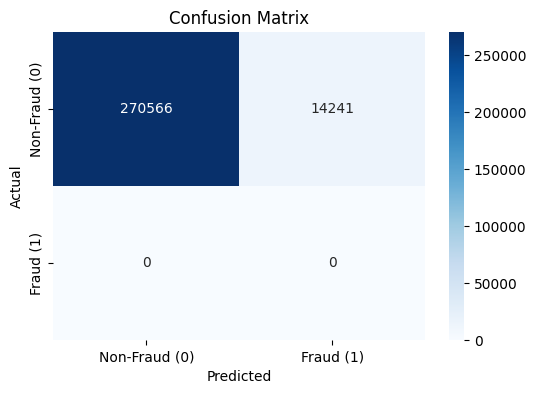

In [15]:
plot_confusion_matrix(y, iso_preds)

# One-Class SVM

In [16]:
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

svm_preds = oc_svm.fit_predict(X_scaled)

svm_preds = [1 if x == -1 else 0 for x in svm_preds]

print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284807
           1       0.00      0.00      0.00         0

    accuracy                           0.95    284807
   macro avg       0.50      0.48      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  nan
Confusion Matrix:


c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

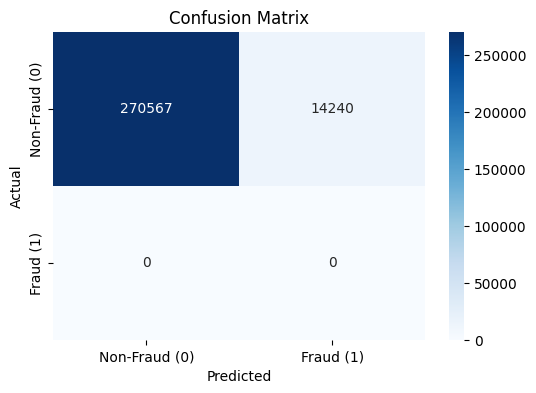

In [17]:
cm = confusion_matrix(y, svm_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# Local Outlier Factor (LOF)

In [18]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

lof_preds = lof.fit_predict(X_scaled)

lof_preds = [1 if x == -1 else 0 for x in lof_preds]

print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284807
           1       0.00      0.00      0.00         0

    accuracy                           0.95    284807
   macro avg       0.50      0.47      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  nan
Confusion Matrix:
[[270566  14241]
 [     0      0]]


c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site

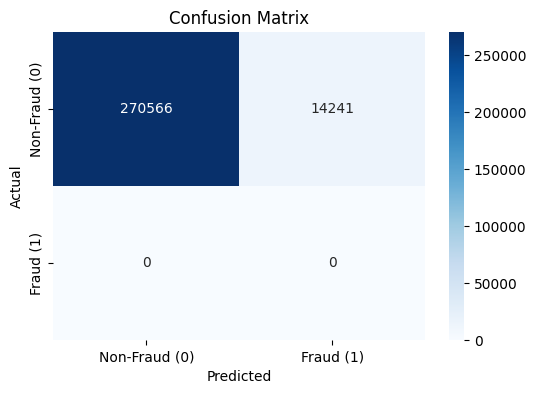

In [19]:
plot_confusion_matrix(y, lof_preds)

# DBSCAN

In [20]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan_preds = dbscan.fit_predict(X_scaled)

dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")
print(confusion_matrix(y, dbscan_preds))

              precision    recall  f1-score   support

           0       1.00      0.22      0.35    284807
           1       0.00      0.00      0.00         0

    accuracy                           0.22    284807
   macro avg       0.50      0.11      0.18    284807
weighted avg       1.00      0.22      0.35    284807

ROC AUC Score:  nan
Confusion Matrix:
[[ 61445 223362]
 [     0      0]]


c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shubham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

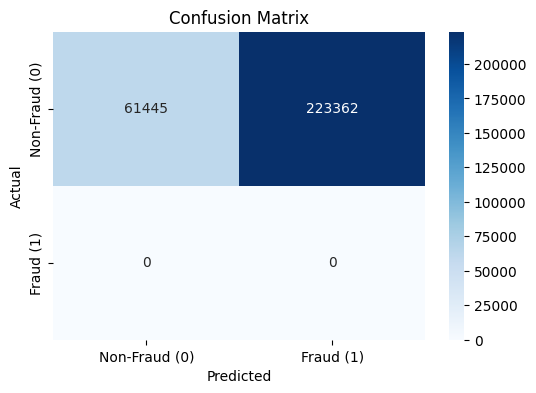

In [21]:
plot_confusion_matrix(y, dbscan_preds)

# Conclusions

## DBSCAN
Achieved the highest recall, flagging 92% of frauds 🚨, which is impressive.
However, the confusion matrix reveals that most transactions were flagged as fraud.
Given that fraud accounts for only 0.2% of transactions, this leads to:
High cost 💸
Significant inconvenience for customers
Conclusion: This makes DBSCAN an impractical solution for fraud detection.

# One-Class SVM and Isolation Forest
Captured around 87% of frauds 🔍 while predicting fewer overall frauds.
Struck a better balance between:
Identifying fraud
Minimizing false positives
Result: A more practical approach for fraud detection with fewer unnecessary disruptions ✅.